In [11]:


import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from utils.base_model import Base3DCNN, Enhanced3DCNN
from utils.data_loader import get_medmnist_dataloaders
from utils.trainer import Trainer
from utils.metrics import evaluate_model, compute_metrics
from utils.visualization import plot_training_history, plot_confusion_matrix
from config import *

print(f"Device: {DEVICE}")
set_seed(42)

Device: cuda


In [12]:
# Load OrganMNIST3D dataset
train_loader, val_loader, test_loader, num_classes = get_medmnist_dataloaders(
    dataset_name='organ',
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers']
)

print(f"Number of classes: {num_classes}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Number of classes: 11
Training batches: 31
Validation batches: 6
Test batches: 20


In [13]:
# Initialize model with new architecture options
from utils.cnn_3d_models import get_3d_model

architecture = MODEL_CONFIG['architecture']

# Create model based on architecture
if architecture in ['resnet18_3d', 'resnet34_3d', 'resnet50_3d', 'densenet121_3d', 'efficientnet3d_b0']:
    # Use new 3D models (ResNet, DenseNet, EfficientNet)
    model = get_3d_model(
        model_name=architecture,
        num_classes=num_classes,
        dropout_rate=MODEL_CONFIG['dropout_rate']
    )
    print(f"✅ Using {architecture.upper().replace('_', '-')}")
elif architecture == 'enhanced':
    model = Enhanced3DCNN(
        in_channels=1,
        num_classes=num_classes,
        dropout_rate=MODEL_CONFIG['dropout_rate']
    )
    print(f"✅ Using Enhanced3DCNN")
else:
    # Default: Base3DCNN
    model = Base3DCNN(
        in_channels=1,
        num_classes=num_classes,
        dropout_rate=MODEL_CONFIG['dropout_rate']
    )
    print(f"✅ Using Base3DCNN")

model = model.to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Architecture: {architecture}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\n💡 To change architecture, edit MODEL_CONFIG['architecture'] in config.py")
print(f"   Options: 'base', 'enhanced', 'resnet18_3d', 'resnet34_3d', 'resnet50_3d',")
print(f"            'densenet121_3d', 'efficientnet3d_b0'")

✅ Using RESNET18-3D

Model Architecture: resnet18_3d
Total parameters: 33,165,643
Trainable parameters: 33,165,643

💡 To change architecture, edit MODEL_CONFIG['architecture'] in config.py
   Options: 'base', 'enhanced', 'resnet18_3d', 'resnet34_3d', 'resnet50_3d',
            'densenet121_3d', 'efficientnet3d_b0'


In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)
scheduler = StepLR(
    optimizer,
    step_size=TRAINING_CONFIG['scheduler_step_size'],
    gamma=TRAINING_CONFIG['scheduler_gamma']
)

# Create trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler
)

print("Training setup complete!")

Training setup complete!


In [15]:
# Train the model
num_epochs = 30
print(f"Training for {num_epochs} epochs...\n")

history = trainer.train(num_epochs=num_epochs)

print("\n" + "="*50)
print("Training completed!")
print(f"Best validation accuracy: {max(history['val_acc']):.4f}")
print("="*50)

Training for 30 epochs...


Epoch 1/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.14it/s]


Train Loss: 1.2938, Train Acc: 0.5922
Val Loss: 1.3367, Val Acc: 0.4596
New best validation accuracy: 0.4596

Epoch 2/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 23.61it/s]


Train Loss: 0.5732, Train Acc: 0.8023
Val Loss: 1.5908, Val Acc: 0.5776
New best validation accuracy: 0.5776

Epoch 3/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 23.48it/s]


Train Loss: 0.4699, Train Acc: 0.8435
Val Loss: 1.8333, Val Acc: 0.5528

Epoch 4/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.46it/s]


Train Loss: 0.3740, Train Acc: 0.8723
Val Loss: 0.2859, Val Acc: 0.9255
New best validation accuracy: 0.9255

Epoch 5/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.45it/s]


Train Loss: 0.3502, Train Acc: 0.8847
Val Loss: 0.7545, Val Acc: 0.7453

Epoch 6/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.75it/s]


Train Loss: 0.2943, Train Acc: 0.9042
Val Loss: 3.1153, Val Acc: 0.4783

Epoch 7/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.25it/s]


Train Loss: 0.2874, Train Acc: 0.9053
Val Loss: 0.4718, Val Acc: 0.8571

Epoch 8/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.29it/s]


Train Loss: 0.2188, Train Acc: 0.9197
Val Loss: 0.2374, Val Acc: 0.8944

Epoch 9/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.33it/s]


Train Loss: 0.1099, Train Acc: 0.9640
Val Loss: 0.2146, Val Acc: 0.9317
New best validation accuracy: 0.9317

Epoch 10/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.45it/s]


Train Loss: 0.1354, Train Acc: 0.9547
Val Loss: 1.5514, Val Acc: 0.6025

Epoch 11/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.41it/s]


Train Loss: 0.1153, Train Acc: 0.9588
Val Loss: 0.0317, Val Acc: 0.9814
New best validation accuracy: 0.9814

Epoch 12/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.92it/s]


Train Loss: 0.0720, Train Acc: 0.9794
Val Loss: 0.1366, Val Acc: 0.9441

Epoch 13/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 23.39it/s]


Train Loss: 0.0529, Train Acc: 0.9835
Val Loss: 0.0505, Val Acc: 0.9814

Epoch 14/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.56it/s]


Train Loss: 0.0403, Train Acc: 0.9887
Val Loss: 0.0792, Val Acc: 0.9752

Epoch 15/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.14it/s]


Train Loss: 0.0175, Train Acc: 0.9949
Val Loss: 0.0512, Val Acc: 0.9876
New best validation accuracy: 0.9876

Epoch 16/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.28it/s]


Train Loss: 0.0148, Train Acc: 0.9959
Val Loss: 0.0731, Val Acc: 0.9814

Epoch 17/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.97it/s]


Train Loss: 0.0202, Train Acc: 0.9928
Val Loss: 4.8706, Val Acc: 0.5093

Epoch 18/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.41it/s]


Train Loss: 0.0300, Train Acc: 0.9928
Val Loss: 0.1622, Val Acc: 0.9627

Epoch 19/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.67it/s]


Train Loss: 0.0207, Train Acc: 0.9938
Val Loss: 0.1056, Val Acc: 0.9814

Epoch 20/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.76it/s]


Train Loss: 0.0610, Train Acc: 0.9763
Val Loss: 0.1013, Val Acc: 0.9752

Epoch 21/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.67it/s]


Train Loss: 0.0354, Train Acc: 0.9876
Val Loss: 0.0759, Val Acc: 0.9752

Epoch 22/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.26it/s]


Train Loss: 0.0110, Train Acc: 0.9969
Val Loss: 0.0643, Val Acc: 0.9627

Epoch 23/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.57it/s]


Train Loss: 0.0207, Train Acc: 0.9938
Val Loss: 0.0724, Val Acc: 0.9689

Epoch 24/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.23it/s]


Train Loss: 0.0103, Train Acc: 0.9979
Val Loss: 0.0338, Val Acc: 0.9814

Epoch 25/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.13it/s]


Train Loss: 0.0073, Train Acc: 0.9979
Val Loss: 0.0277, Val Acc: 0.9814

Epoch 26/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.69it/s]


Train Loss: 0.0045, Train Acc: 1.0000
Val Loss: 0.0533, Val Acc: 0.9752

Epoch 27/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 23.53it/s]


Train Loss: 0.0067, Train Acc: 0.9979
Val Loss: 0.0243, Val Acc: 0.9938
New best validation accuracy: 0.9938

Epoch 28/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.08it/s]


Train Loss: 0.0063, Train Acc: 0.9979
Val Loss: 0.0217, Val Acc: 0.9876

Epoch 29/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.16it/s]


Train Loss: 0.0030, Train Acc: 1.0000
Val Loss: 0.0422, Val Acc: 0.9814

Epoch 30/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.86it/s]

Train Loss: 0.0076, Train Acc: 0.9990
Val Loss: 0.0371, Val Acc: 0.9876

Training completed!
Best validation accuracy: 0.9938


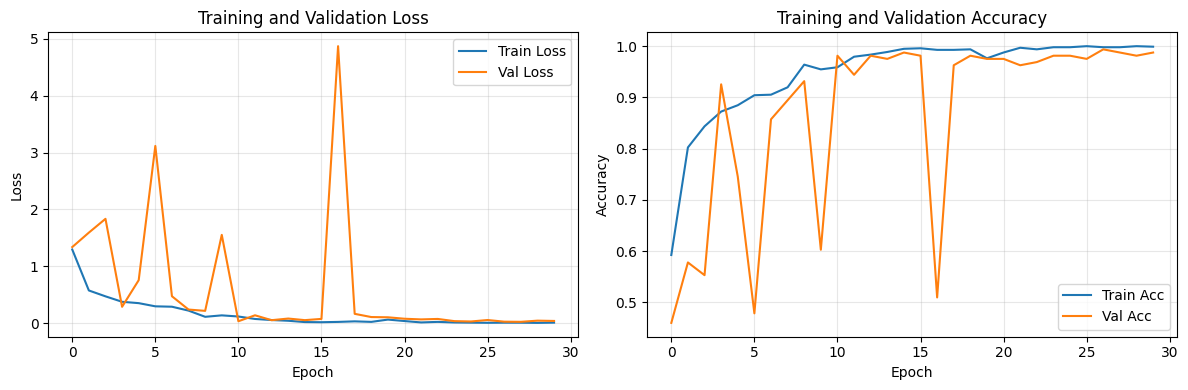

In [16]:
plot_training_history(history, save_path='../figures/baseline_training_history.png')

In [17]:
# Evaluate on test set
print("Evaluating on test set...\n")
test_metrics, test_preds, test_labels = evaluate_model(model, test_loader, DEVICE)

print("Test Set Results:")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1-Score:  {test_metrics['f1_score']:.4f}")

print("\nPer-class metrics:")
for i, organ_name in ORGAN_CLASSES.items():
    if i < len(test_metrics['per_class']['f1_score']):
        f1 = test_metrics['per_class']['f1_score'][i]
        print(f"  {organ_name:15s}: F1={f1:.4f}")

Evaluating on test set...

Test Set Results:
  Accuracy:  0.9082
  Precision: 0.9107
  Recall:    0.9082
  F1-Score:  0.9082

Per-class metrics:
  bladder        : F1=0.9855
  femur-left     : F1=0.8722
  femur-right    : F1=0.8175
  heart          : F1=0.8873
  kidney-left    : F1=0.8710
  kidney-right   : F1=0.9197
  liver          : F1=0.9434
  lung-left      : F1=1.0000
  lung-right     : F1=1.0000
  pancreas       : F1=0.9130
  spleen         : F1=0.9254


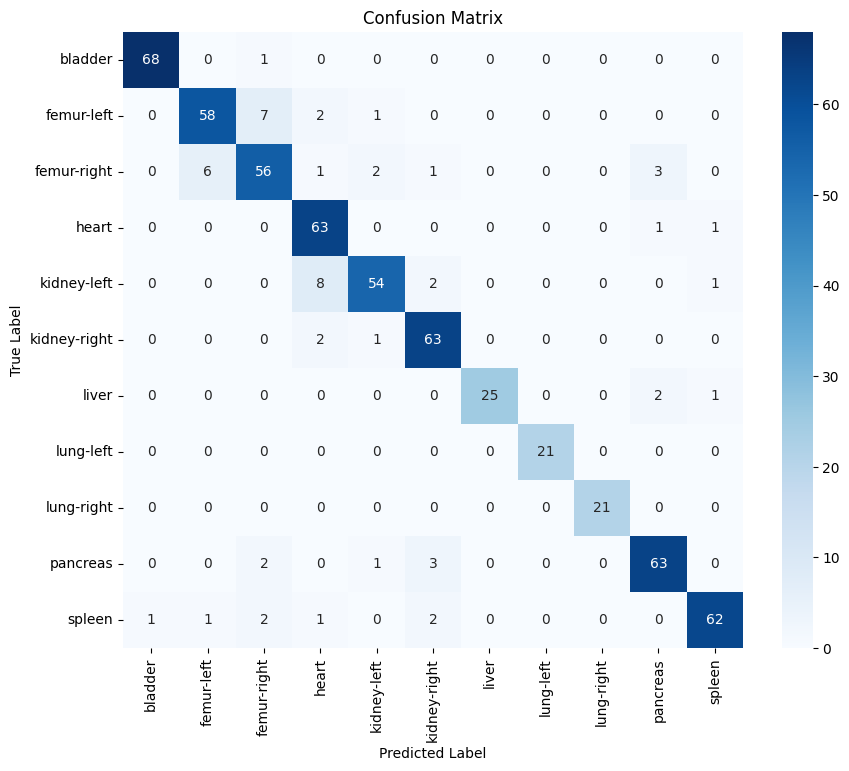

In [18]:
# Plot confusion matrix
class_names = [ORGAN_CLASSES[i] for i in range(num_classes)]
plot_confusion_matrix(
    test_metrics['confusion_matrix'],
    class_names=class_names,
    save_path='../figures/baseline_confusion_matrix.png'
)

In [19]:
# Save trained model
import os
os.makedirs('../models', exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'test_metrics': test_metrics,
    'num_classes': num_classes,
}, '../models/baseline_flat_model.pth')

print("Model saved to '../models/baseline_flat_model.pth'")

Model saved to '../models/baseline_flat_model.pth'


In [ ]:
# Save trained model
import os
os.makedirs('../models', exist_ok=True)

# Save with architecture-specific name for notebook 04 compatibility
model_filename = f'../models/{architecture}_baseline.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'test_metrics': test_metrics,
    'num_classes': num_classes,
}, model_filename)

print(f"Model saved to '{model_filename}'")